# CN Number Calculation
This notebook calculate Curve Number (CN) for a given HUC:
1. Required data: 
    * NLCD Landuse Data (downloaded from our Azure storage account)
    * Hydrologic Soils Group (HSG) data, downloaded from ssurgo database
    * FEMA CN lookup table in a csv (provided by Johnson, Danielle, danielle.johnson@stantec.com)
2. CN averaged method: 
    * For a given HUC, we compute CN for each combination of land use and soil condition, and then average all the pixel's CN as the final average CN for this HUC

In [1]:
import sys
import os
import pathlib as pl
import json
import rasterio.mask
sys.path.append('..')
home = pl.Path(os.getcwd())

In [2]:
from src.modules.curve_number.utils_CN import *
import src.modules.curve_number.ssurgo_CN as ssurgo

## user defined variables

In [3]:
#user defined whether you want the CN for the huc12 or gage site
watershed_type = 'huc' #other options are 'gage' or 'huc'
study_id = 'ff' #only required for site option

# The option of dealing with dual HSG and nodata, see soilvar_CN function defined below. By default is 3: A/D = D and nodata = NAN
assume_drained_dual_HSG_num = False

# If use FEMA's CN look-up table (provided by Danielle Johnson, danielle.johnson@stantec.com, higher CN estimates, e.g. Wetland CNs are 98 in this table for all HSGs)
FEMA_option = False

## initialize project area

In [4]:
#get basin information
with open(home/'Inputs'/'huc12.txt','r') as tfile:
    huc12 = tfile.read()
    
if watershed_type == 'site':
    basin = 'basin'
    basin_gdf = gpd.read_file(home/'Inputs'/f'{basin}_{study_id}.geojson')
else:
    basin = 'huc'

    if watershed_type == 'gage': 
        with open(home/'Inputs'/'stream_gage.txt','r') as tfile:
            stream_gage = tfile.read()
        basin_gdf = gpd.read_file(home/'Outputs'/huc12/f'{basin}_{stream_gage}.geojson')
    else:
        basin_gdf = gpd.read_file(home/'Outputs'/huc12/f'{basin}_{huc12}.geojson')


In [5]:
#buffer of 2500 ft for RAS6. will be clipped for basin CN average
basin_gdf_buff = basin_gdf.copy()
basin_gdf_buff['geometry'] = basin_gdf.to_crs(epsg=3857).buffer(800)

## get soil data

## get landuse data

In [6]:
soil_gpd = ssurgo.soilvar_CN(home/'Outputs'/huc12,basin_gdf_buff,assume_drained_dual_HSG_num)

Transforming aoi to WGS 84 for compatibility with SSURGO
submitting POST request to: https://sdmdataaccess.nrcs.usda.gov/Tabular/SDMTabularService/post.rest
getting all dominant soil condition values from the SSURGO database using mapunit aggregated attributes


In [7]:
soil_gpd.to_file(home/'Outputs'/"soil_out.shp")

In [10]:
#confirm land use tiff is available for local HUC2
# landcover = f'nlcd_2019_land_cover_l48_20210604_{huc12[:2]}.tif'
# assert os.path.exists(home/'Inputs'/'nlcd'/landcover)

##Land use for usvi
landcover = home/'Inputs'/'nlcd'/'IITF_JRS02_usbvi_landcov1_geotiff.tif'
#landcover_conus = f'nlcd_2019_land_cover_l48_20210604_{huc12[:2]}.tif'
assert os.path.exists(home/'Inputs'/'nlcd'/landcover)

In [24]:
da_cropped

<xarray.DataArray (band: 1, y: 8345, x: 6404)> Size: 214MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 8345, 6404), dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 67kB 2.129e+06 2.129e+06 ... 1.997e+06 1.997e+06
  * x            (x) float64 51kB -7.249e+06 -7.249e+06 ... -7.148e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              nan

In [26]:
#set soils data as mask for reading array
soil_crs = f'EPSG:{soil_gpd.crs.to_epsg()}'

# 1. Read the raster
da = rioxarray.open_rasterio(home/'Inputs'/'nlcd'/landcover, masked=True)

# 2. Reproject to a new CRS (e.g., EPSG:4326)
da_reprojected = da.rio.reproject(soil_crs)

# 3. Crop (Clip) to specific shape
da_cropped = da_reprojected.rio.clip(soil_gpd.geometry, drop=False)
da_cropped.rio.write_nodata(-9999, inplace=True)
# Ensure the data type is correct
da_cropped = da_cropped.astype('int16')
# 4. Save the result
da_cropped.rio.to_raster(home/'Outputs'/huc12/'cropped_lu.tif', compress="LZW")

In [27]:
lu_gpd = polygonize_raster(home/'Outputs'/huc12/'cropped_lu.tif',mask = None)

## merge datasets and perform lookup to get CN values

In [28]:
#create coupled CN layer
CN = soil_gpd.overlay(lu_gpd,how='intersection')

In [ ]:
#set soil type to D if unknown
CN.loc[CN["hydgrpdcd"].isna() == True,"hydgrpdcd"] = 334.

In [39]:
# Read the CN look-up table
if FEMA_option == False:
    CN_lookup = pd.read_csv(home/'reference'/'CN_Table_FEMA.csv')
else:
    CN_lookup = pd.read_csv(home/'reference'/'CN_Table.csv')

# Index to CN dictionary
CN_dict = dict(zip(CN_lookup.Index, CN_lookup.CN_Join))
# Class-name to CN dictionary
CN_name = dict(zip(CN_lookup.Index, CN_lookup.GDCode))

####USVI CODE#######
usvi_lookup = pd.read_csv(home/'reference'/'usvi_translation.csv')
usvi_dict = dict(zip(usvi_lookup.usvi, usvi_lookup.nlcd))

In [40]:
##USVI CODE ####
CN['CN_ref_code'] = CN.apply(lambda x: 0 if x.hydgrpdcd == 330 else int(x.hydgrpdcd)*int(usvi_dict[x.raster_val]),axis =1)
###CONUS CODE
# CN['CN_ref_code'] = CN.apply(lambda x: 0 if x.hydgrpdcd == 330 else int(x.hydgrpdcd)*int(x.raster_val),axis =1)

In [41]:
CN['CN'] = CN.apply(lambda x: replace_with_dict(x.CN_ref_code,CN_dict),axis=1)

## results

In [42]:
# Convert zero to nan
CN['CN'] = CN['CN'].replace(0,np.nan)
#save to file for RAS 6
CN.to_file(home/'Outputs'/huc12/'CN_layer.shp')

In [43]:
#convert to equal area projection
CN_clipped = CN.overlay(basin_gdf.to_crs(epsg=3857),how='intersection')
CN_albers = CN_clipped.to_crs(epsg=5070)
# Compute the mean value of the CN array for this HUC, ignoring nan
CN_albers['wa'] = CN_albers.CN * (CN_albers.area/ CN_albers.area.sum())
wa = int(CN_albers['wa'].sum())

In [44]:
print(f'The averaged CN for huc {huc12} is: {wa}')

The averaged CN for huc 210200010203 is: 76


In [45]:
#write to output folder
with open(home/'Outputs'/huc12/'CN.txt', 'w') as txt:
    txt.write(str(wa))

<Axes: >

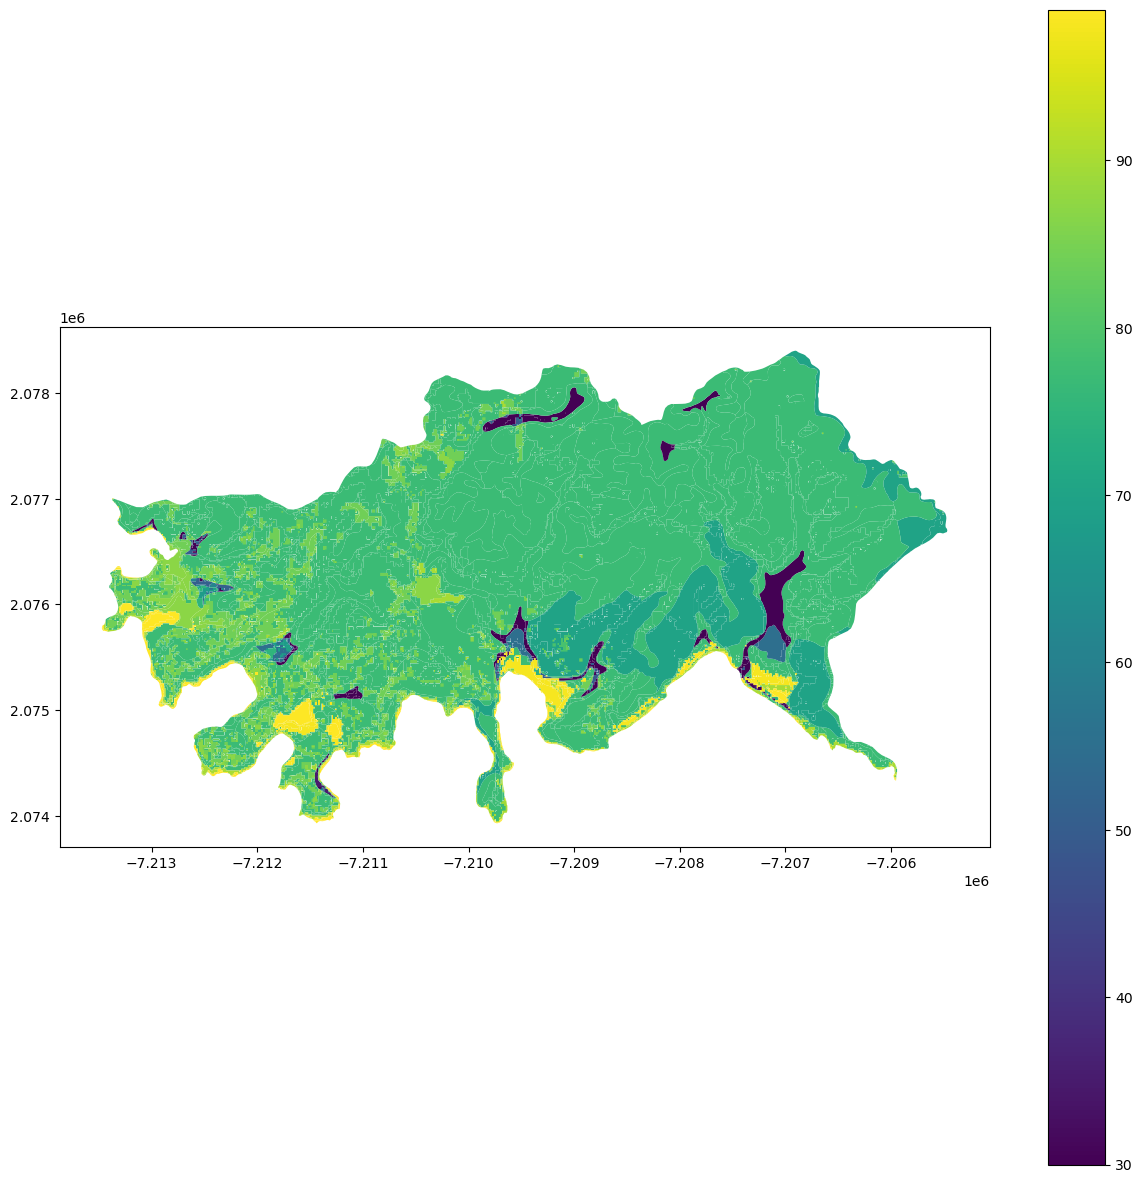

In [46]:
CN_clipped.plot(column='CN',legend=True,figsize=(15, 15))